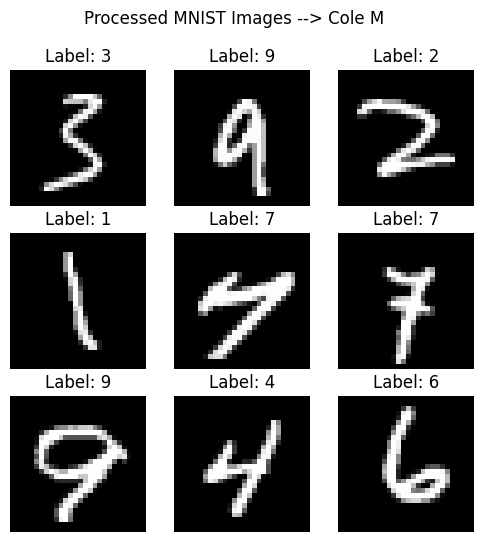

MNIST_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Linear-4                  [-1, 128]       1,605,760
            Linear-5                   [-1, 10]           1,290
Total params: 1,625,866
Trainable params: 1,625,866
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

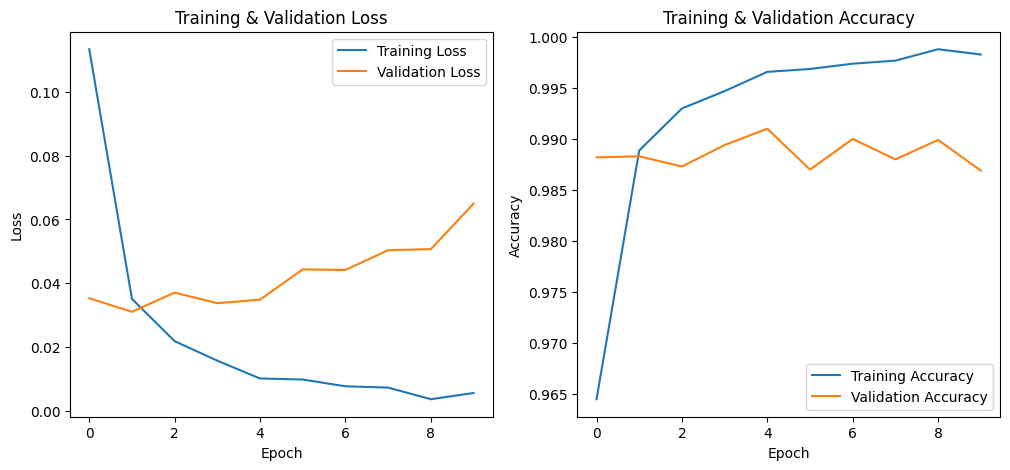

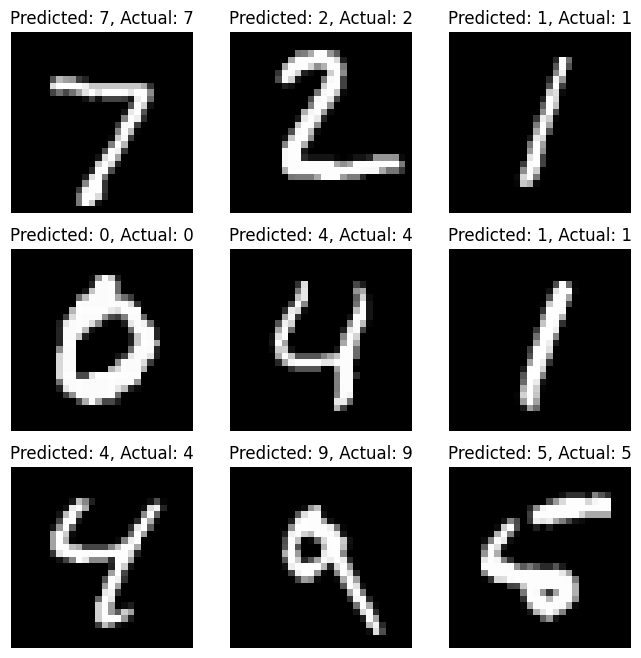

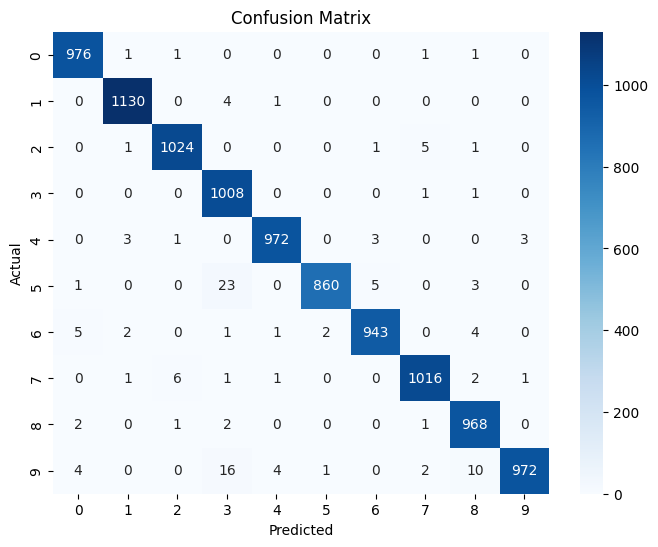

In [2]:
#**Total Images Used in Our Dataset** 70,000 (split 60,000 for training, 10,000 for testing)
#**Number of Classes** 10 (digits from 0 to 9)
#**Image Dimensions** 28×28 pixels, in grayscale
#**Format** Each image is a single-channel 28×28 pixel matrix 


import sys
#one time
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install torchsummary
#!{sys.executable} -m pip install scikit-learn seaborn
from sklearn.metrics import confusion_matrix

import seaborn as sns
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torch.optim as optim
from torchsummary import summary


#define transformations 
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.1307,), (0.3081,))  #mean and Std for MNIST
])

#download and load the MNIST dataset
train_dataset = MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = MNIST(root="./data", train=False, download=True, transform=transform)

#create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


#print("MNIST dataset loaded successfully!")
#print(f"Training set size: {len(train_dataset)} images")
#print(f"Testing set size: {len(test_dataset)} images")

#normalizing the MNIST dataset ensures that pixel values that starts normally at 0 to 255 are now scaled to a standard range!
def show_processed_images(data_loader, num_images=9):
    images, labels = next(iter(data_loader))  # Get a batch of images
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))

    for i, ax in enumerate(axes.flat):
        img = images[i].squeeze().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis("off")

    plt.suptitle("Processed MNIST Images --> Cole M", fontsize=12)
    plt.show()

show_processed_images(train_loader)


class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        #convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  # 28x28 -> 28x28
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # 28x28 -> 28x28
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 28x28 -> 14x14
        self.fc1 = nn.Linear(64 * 14 * 14, 128)  #fully connected layer
        self.fc2 = nn.Linear(128, 10)  #output layer (10 classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)  
        #flatten for FC layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  #no activation, softmax applied during loss calculation
        return x

#instantiate model
model = MNIST_CNN()
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()  #suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  #adam optimizer
summary(model, (1, 28, 28))

num_epochs = 10  #10 epochs to start us off with
train_losses = []
test_losses = []
train_acc = []
test_acc = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  #reset gradients
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()  # backpropagation
        optimizer.step()  #update weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_acc.append(correct / total)

    #evaluate on our test set
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():  #disable gradients for faster inference
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_acc.append(correct / total)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_losses[-1]:.4f}, Acc: {train_acc[-1]*100:.2f}%, Val Loss: {test_losses[-1]:.4f}, Val Acc: {test_acc[-1]*100:.2f}%")

print("Training over :)")


# plot Training & Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cole Training & Validation Loss')
plt.legend()

# plot Train, Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Cole Training & Validation Accuracy')
plt.legend()
plt.show()

# sample Predictions vs. Actual Labels
def show_predictions(model, data_loader, device, num_images=9):
    model.eval()
    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        img = images[i].cpu().squeeze().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Predicted: {predicted[i].item()}, Actual: {labels[i].item()}")
        ax.axis("off")
    plt.show()

show_predictions(model, test_loader, device)

# confusion Matrix
def plot_confusion_matrix(model, data_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Cole Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, test_loader, device, list(range(10)))

